In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

PyTorch Version:  1.8.0
Torchvision Version:  0.9.0
cuda


In [2]:
def getData(mode):
    if mode == 'train':
        img = pd.read_csv('train_img.csv')
        label = pd.read_csv('train_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)
    else:
        img = pd.read_csv('test_img.csv')
        label = pd.read_csv('test_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)

In [3]:
class RetinopathyLoader(Dataset):
    def __init__(self, root, mode):
        """
        Args:
            root (string): Root path of the dataset.
            mode : Indicate procedure status(training or testing)

            self.img_name (string list): String list that store all image names.
            self.label (int or float list): Numerical list that store all ground truth label values.
        """
        self.root = root
        self.img_name, self.label = getData(mode)
        self.mode = mode
        
        if mode == 'train':
            self.transforms = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),transforms.ToTensor(),
                                                  transforms.Normalize([0.5769, 0.3852, 0.2649],[0.1061, 0.0809, 0.0555])])
        else:
            self.transforms = transforms.Compose([transforms.ToTensor(),
                                                  transforms.Normalize([0.5769, 0.3852, 0.2649],[0.1061, 0.0809, 0.0555])])
        
        print("> Found %d images..." % (len(self.img_name)))

    def __len__(self):
        """'return the size of dataset"""
        return len(self.img_name)

    def __getitem__(self, index):
        """something you should implement here"""

        """
           step1. Get the image path from 'self.img_name' and load it.
                  hint : path = root + self.img_name[index] + '.jpeg'
           
           step2. Get the ground truth label from self.label
                     
           step3. Transform the .jpeg rgb images during the training phase, such as resizing, random flipping, 
                  rotation, cropping, normalization etc. But at the beginning, I suggest you follow the hints. 
                       
                  In the testing phase, if you have a normalization process during the training phase, you only need 
                  to normalize the data. 
                  
                  hints : Convert the pixel value to [0, 1]
                          Transpose the image shape from [H, W, C] to [C, H, W]
                         
            step4. Return processed image and label
        """
        path = os.path.join(self.root, self.img_name[index]+'.jpeg') #step1
        img = Image.open(path) #step1
        label = self.label[index] #step2
        img = self.transforms(img) #step3

        return img, label #step4

# ResNet Model

In [4]:
class ResNet(nn.Module):
    def __init__(self, num_classes=5, option='resnet18', pretrained=True):
        super(ResNet, self).__init__()
        if option == 'resnet18':
            self.model = models.resnet18(pretrained=pretrained)
        elif option == 'resnet50':
            self.model = models.resnet50(pretrained=pretrained)
        
        if pretrained:
            for param in self.model.parameters():
                param.requires_grad = False
                
        num_neurons = self.model.fc.in_features
        self.model.fc = nn.Linear(num_neurons, num_classes)
        
    def forward(self, x):
        out = self.model(x)
        
        return out

# Train and Test

In [5]:
def train_test(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()
    
    acc_train = []
    acc_test = []
    
    best_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    model.to(device)
    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data, label in dataloaders[phase]:
                data = data.to(device)
                label = label.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    # mode we calculate the loss by summing the final output and the auxiliary output
                    # but in testing we only consider the final output.
                    pred = model(data)
                    loss = criterion(pred, label)
                    
                    _, preds = torch.max(pred, 1)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * data.size(0)
                running_corrects += torch.sum(preds == label.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'test':
                acc_test.append(epoch_acc)
            else:
                acc_train.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:.2f} %'.format(best_acc * 100))
    
    return torch.Tensor(acc_train).numpy(), torch.Tensor(acc_test).numpy(), best_wts

# Plot

In [6]:
def plot(dataframe):
    fig = plt.figure(figsize=(10,6))
    for name in dataframe.columns[1:]:
        plt.plot('epoch', name, data=dataframe)
    plt.title('Result Comparision')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy(%)')
    plt.legend()
    
    return fig

In [7]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=True, title='Normalized confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return ax

# Evaluate

In [8]:
def evaluate(model, loader):
    model.eval()
    acc = 0
    preds = torch.tensor([]).cuda()
    for data, label in loader:
        data = data.to(device)
        label = label.to(device)
        pred = model(data)
        preds = torch.cat((preds, torch.flatten(pred.max(dim=1)[1])), dim=0)
        acc += pred.max(dim=1)[1].eq(label).sum().item()
    
    acc = 100.*acc / len(loader.dataset)
    
    return acc, preds

# Show accuracy

In [9]:
def show_acc(option, file_name, pretrained):
    model = ResNet(num_classes=5, option=option, pretrained=pretrained)
    model.load_state_dict(torch.load(file_name))
    model.to(device)

    acc, preds = evaluate(model, loader['test'])
    print(f'accuracy: {acc:.2f}%')
    
    return preds.data.cpu().numpy()

# Hyperparameter

In [10]:
batch_size = 8
lr = 1e-3
num_epochs_18 = 15
num_epochs_50 = 10
momentum = 0.9
weight_decay = 5e-4
criterion = nn.CrossEntropyLoss()

# DataLoader

In [11]:
loader = {}

data_train = RetinopathyLoader(root='data', mode='train')
loader['train'] = DataLoader(dataset=data_train, batch_size=batch_size, shuffle=True)

data_test = RetinopathyLoader(root='data', mode='test')
loader['test'] = DataLoader(dataset=data_test, batch_size=batch_size, shuffle=False)

> Found 28099 images...
> Found 7025 images...


# ResNet18

## with pretrained

In [12]:
ResNet18_w = ResNet(num_classes=5, option='resnet18', pretrained=True)
# feature extraction
params_to_update = []
for name, param in ResNet18_w.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
optimizer = optim.SGD(params_to_update, lr=lr, momentum=momentum, weight_decay=weight_decay)
_, _, _ = train_test(model=ResNet18_w, dataloaders=loader, criterion=criterion, optimizer=optimizer, num_epochs=5)

Epoch 1/5
----------
train Loss: 0.8504 Acc: 0.7290
test Loss: 0.7818 Acc: 0.7485

Epoch 2/5
----------
train Loss: 0.8216 Acc: 0.7321
test Loss: 0.8968 Acc: 0.7402

Epoch 3/5
----------
train Loss: 0.8118 Acc: 0.7329
test Loss: 0.8095 Acc: 0.7426

Epoch 4/5
----------
train Loss: 0.8091 Acc: 0.7352
test Loss: 0.9099 Acc: 0.7431

Epoch 5/5
----------
train Loss: 0.8080 Acc: 0.7329
test Loss: 0.7577 Acc: 0.7478

Training complete in 32m 9s
Best test Acc: 74.85 %


In [13]:
# fine-tune
for param in ResNet18_w.parameters():
    param.requires_grad = True
optimizer = optim.SGD(ResNet18_w.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
acc_train, acc_test, best_wts = train_test(model=ResNet18_w, dataloaders=loader, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs_18)

Epoch 1/15
----------
train Loss: 0.7464 Acc: 0.7560
test Loss: 0.6849 Acc: 0.7853

Epoch 2/15
----------
train Loss: 0.6485 Acc: 0.7862
test Loss: 0.6127 Acc: 0.7986

Epoch 3/15
----------
train Loss: 0.6102 Acc: 0.8002
test Loss: 0.5958 Acc: 0.8019

Epoch 4/15
----------
train Loss: 0.5845 Acc: 0.8085
test Loss: 0.5712 Acc: 0.8155

Epoch 5/15
----------
train Loss: 0.5665 Acc: 0.8121
test Loss: 0.5756 Acc: 0.8093

Epoch 6/15
----------
train Loss: 0.5495 Acc: 0.8177
test Loss: 0.5923 Acc: 0.8056

Epoch 7/15
----------
train Loss: 0.5393 Acc: 0.8223
test Loss: 0.5557 Acc: 0.8192

Epoch 8/15
----------
train Loss: 0.5268 Acc: 0.8243
test Loss: 0.6189 Acc: 0.7999

Epoch 9/15
----------
train Loss: 0.5187 Acc: 0.8290
test Loss: 0.5656 Acc: 0.8175

Epoch 10/15
----------
train Loss: 0.5046 Acc: 0.8301
test Loss: 0.5760 Acc: 0.8151

Epoch 11/15
----------
train Loss: 0.5012 Acc: 0.8324
test Loss: 0.5683 Acc: 0.8195

Epoch 12/15
----------
train Loss: 0.4851 Acc: 0.8368
test Loss: 0.5564 Ac

In [14]:
torch.save(best_wts, 'ResNet18_w_pretrained.pt')

df18 = pd.DataFrame()
df18['epoch'] = range(1, num_epochs_18+1)
df18['Train(with pretraining)'] = acc_train
df18['Test(with pretraining)'] = acc_test

## Show the highest accuarcy

In [12]:
with torch.no_grad():
    preds = show_acc(option='resnet18', file_name='ResNet18_w_pretrained.pt', pretrained=True)

accuracy: 81.96%


## Plot confusion matrix

<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

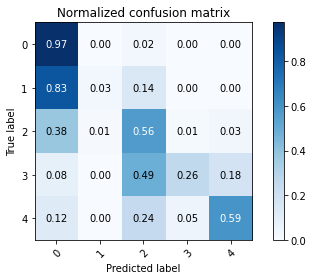

In [13]:
classes = np.array(['0', '1', '2', '3', '4'])

plot_confusion_matrix(y_true=data_test.label, y_pred=preds, classes=classes)

## without pretrained

In [17]:
ResNet18_wo = ResNet(num_classes=5, option='resnet18', pretrained=False)
optimizer = optim.SGD(ResNet18_wo.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
acc_train, acc_test, best_wts = train_test(model=ResNet18_wo, dataloaders=loader, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs_18)

Epoch 1/15
----------
train Loss: 0.8914 Acc: 0.7330
test Loss: 0.8747 Acc: 0.7304

Epoch 2/15
----------
train Loss: 0.8714 Acc: 0.7349
test Loss: 0.8619 Acc: 0.7334

Epoch 3/15
----------
train Loss: 0.8640 Acc: 0.7350
test Loss: 0.8517 Acc: 0.7334

Epoch 4/15
----------
train Loss: 0.8598 Acc: 0.7350
test Loss: 0.8464 Acc: 0.7321

Epoch 5/15
----------
train Loss: 0.8591 Acc: 0.7351
test Loss: 0.8492 Acc: 0.7330

Epoch 6/15
----------
train Loss: 0.8573 Acc: 0.7351
test Loss: 0.8553 Acc: 0.7320

Epoch 7/15
----------
train Loss: 0.8552 Acc: 0.7350
test Loss: 0.8448 Acc: 0.7320

Epoch 8/15
----------
train Loss: 0.8530 Acc: 0.7351
test Loss: 0.8559 Acc: 0.7327

Epoch 9/15
----------
train Loss: 0.8515 Acc: 0.7351
test Loss: 0.9141 Acc: 0.7023

Epoch 10/15
----------
train Loss: 0.8520 Acc: 0.7351
test Loss: 0.8460 Acc: 0.7320

Epoch 11/15
----------
train Loss: 0.8499 Acc: 0.7350
test Loss: 0.8438 Acc: 0.7318

Epoch 12/15
----------
train Loss: 0.8499 Acc: 0.7350
test Loss: 0.8538 Ac

In [18]:
torch.save(best_wts, 'ResNet18_wo_pretrained.pt')

df18['Train(w/o pretraining)'] = acc_train
df18['Test(w/o pretraining)'] = acc_test

In [13]:
with torch.no_grad():
    preds = show_acc(option='resnet18', file_name='ResNet18_wo_pretrained.pt', pretrained=False)

accuracy: 73.34%


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

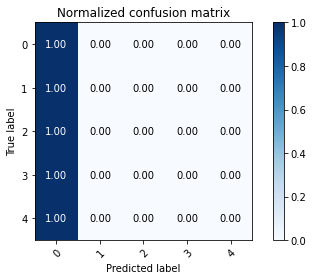

In [15]:
plot_confusion_matrix(y_true=data_test.label, y_pred=preds, classes=classes)

## Plot accuracy

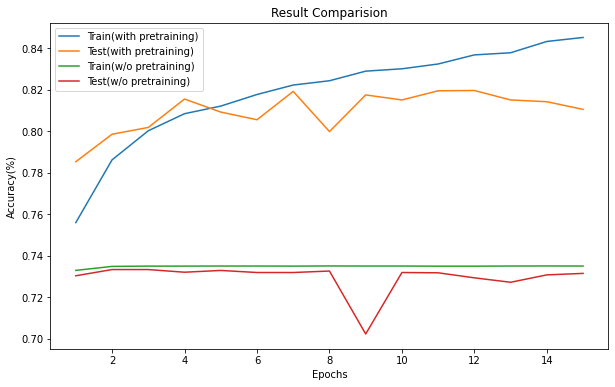

In [21]:
figure = plot(df18)

# ResNet 50

## with pretrained

In [16]:
ResNet50_w = ResNet(num_classes=5, option='resnet50', pretrained=True)
# feature extraction
params_to_update = []
for name, param in ResNet50_w.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
optimizer = optim.SGD(params_to_update, lr=lr, momentum=momentum, weight_decay=weight_decay)
_, _, _ = train_test(model=ResNet50_w, dataloaders=loader, criterion=criterion, optimizer=optimizer, num_epochs=5)

Epoch 1/5
----------
train Loss: 0.8563 Acc: 0.7290
test Loss: 0.7839 Acc: 0.7425

Epoch 2/5
----------
train Loss: 0.8333 Acc: 0.7311
test Loss: 0.7836 Acc: 0.7429

Epoch 3/5
----------
train Loss: 0.8229 Acc: 0.7332
test Loss: 0.7901 Acc: 0.7425

Epoch 4/5
----------
train Loss: 0.8166 Acc: 0.7316
test Loss: 0.7756 Acc: 0.7293

Epoch 5/5
----------
train Loss: 0.8080 Acc: 0.7361
test Loss: 0.7660 Acc: 0.7472

Training complete in 62m 9s
Best test Acc: 74.72 %


In [17]:
# fine-tune
for param in ResNet50_w.parameters():
    param.requires_grad = True
optimizer = optim.SGD(ResNet50_w.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
acc_train, acc_test, best_wts = train_test(model=ResNet50_w, dataloaders=loader, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs_50)

Epoch 1/10
----------
train Loss: 0.7134 Acc: 0.7653
test Loss: 0.6226 Acc: 0.7889

Epoch 2/10
----------
train Loss: 0.6177 Acc: 0.7978
test Loss: 0.6359 Acc: 0.8028

Epoch 3/10
----------
train Loss: 0.5816 Acc: 0.8087
test Loss: 0.5800 Acc: 0.8094

Epoch 4/10
----------
train Loss: 0.5588 Acc: 0.8172
test Loss: 0.5666 Acc: 0.8132

Epoch 5/10
----------
train Loss: 0.5436 Acc: 0.8206
test Loss: 0.5695 Acc: 0.8140

Epoch 6/10
----------
train Loss: 0.5274 Acc: 0.8259
test Loss: 0.5760 Acc: 0.8175

Epoch 7/10
----------
train Loss: 0.5134 Acc: 0.8289
test Loss: 0.5517 Acc: 0.8225

Epoch 8/10
----------
train Loss: 0.5056 Acc: 0.8308
test Loss: 0.5429 Acc: 0.8201

Epoch 9/10
----------
train Loss: 0.4970 Acc: 0.8343
test Loss: 0.5509 Acc: 0.8204

Epoch 10/10
----------
train Loss: 0.4820 Acc: 0.8373
test Loss: 0.5625 Acc: 0.8172

Training complete in 572m 46s
Best test Acc: 82.25 %


In [18]:
torch.save(best_wts, 'ResNet50_w_pretrained.pt')

df50 = pd.DataFrame()
df50['epoch'] = range(1, num_epochs_50+1)
df50['Train(with pretraining)'] = acc_train
df50['Test(with pretraining)'] = acc_test

In [14]:
with torch.no_grad():
    preds = show_acc(option='resnet50', file_name='ResNet50_w_pretrained.pt', pretrained=True)

accuracy: 82.25%


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

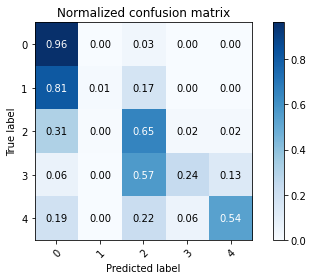

In [20]:
plot_confusion_matrix(y_true=data_test.label, y_pred=preds, classes=classes)

## without pretrained

In [12]:
ResNet50_wo = ResNet(num_classes=5, option='resnet50', pretrained=False)
optimizer = optim.SGD(ResNet50_wo.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
acc_train, acc_test, best_wts = train_test(model=ResNet50_wo, dataloaders=loader, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs_50)

Epoch 1/10
----------
train Loss: 0.9391 Acc: 0.7254
test Loss: 1.0178 Acc: 0.7247

Epoch 2/10
----------
train Loss: 0.8937 Acc: 0.7319
test Loss: 2.0068 Acc: 0.7132

Epoch 3/10
----------
train Loss: 0.8835 Acc: 0.7332
test Loss: 2.4562 Acc: 0.7200

Epoch 4/10
----------
train Loss: 0.8729 Acc: 0.7345
test Loss: 1.1605 Acc: 0.7193

Epoch 5/10
----------
train Loss: 0.8690 Acc: 0.7347
test Loss: 1.0006 Acc: 0.7318

Epoch 6/10
----------
train Loss: 0.8688 Acc: 0.7348
test Loss: 0.9979 Acc: 0.7335

Epoch 7/10
----------
train Loss: 0.8655 Acc: 0.7350
test Loss: 11.4542 Acc: 0.6877

Epoch 8/10
----------
train Loss: 0.8622 Acc: 0.7348
test Loss: 12.9362 Acc: 0.6488

Epoch 9/10
----------
train Loss: 0.8597 Acc: 0.7351
test Loss: 1.8532 Acc: 0.7177

Epoch 10/10
----------
train Loss: 0.8579 Acc: 0.7350
test Loss: 0.8825 Acc: 0.7334

Training complete in 303m 29s
Best test Acc: 73.35 %


In [15]:
torch.save(best_wts, 'ResNet50_wo_pretrained.pt')

df50['Train(w/o pretraining)'] = acc_train
df50['Test(w/o pretraining)'] = acc_test

In [12]:
with torch.no_grad():
    preds = show_acc(option='resnet50', file_name='ResNet50_wo_pretrained.pt', pretrained=False)

accuracy: 73.35%


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

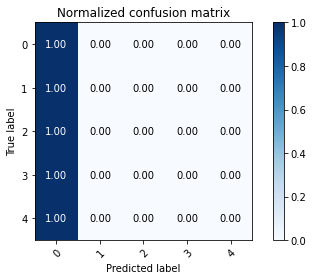

In [14]:
plot_confusion_matrix(y_true=data_test.label, y_pred=preds, classes=classes)

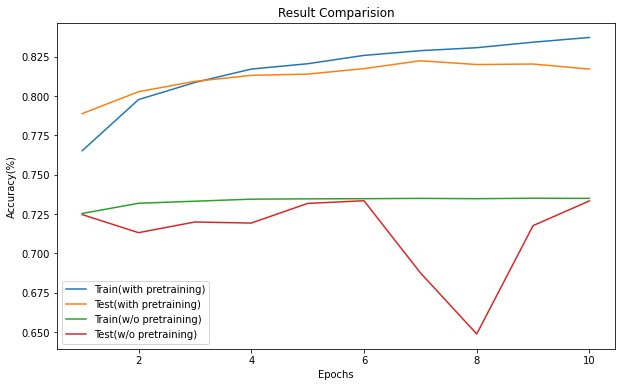

In [17]:
figure = plot(df50)